In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(export))
R.Version()

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”


$platform
[1] "x86_64-apple-darwin17.0"

$arch
[1] "x86_64"

$os
[1] "darwin17.0"

$system
[1] "x86_64, darwin17.0"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.2"

$year
[1] "2020"

$month
[1] "06"

$day
[1] "22"

$`svn rev`
[1] "78730"

$language
[1] "R"

$version.string
[1] "R version 4.0.2 (2020-06-22)"

$nickname
[1] "Taking Off Again"

# Import data

## - Promethion

In [2]:
profile <- read.csv(file = "/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/data/process/fig2_stat_corrected.csv", as.is = TRUE)
profile$Diet <- as.factor(profile$Diet)
profile$Diet <- factor(profile$Diet, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
profile$MouseID <- ordered(profile$MouseID)
profile$MouseID <- as.factor(profile$MouseID); head(profile)

,Time,Diet,Cycle,MouseID,EE,VO2,VCO2,VH2O,RER
,<chr>,<fct>,<chr>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Cycle1:06:00-07:00,LFD,light,1,0.5404855,1.817773,1.667495,0.07543786,0.9165888
2,Cycle1:07:00-08:00,LFD,light,1,0.4461322,1.506156,1.356034,0.09581117,0.8918554
3,Cycle1:08:00-09:00,LFD,light,1,0.3800183,1.302917,1.083944,0.06242484,0.8325571
4,Cycle1:09:00-10:00,LFD,light,1,0.5073735,1.732713,1.471611,0.07426177,0.8477622
5,Cycle1:10:00-11:00,LFD,light,1,0.4239801,1.468392,1.156785,0.08923397,0.7837234
6,Cycle1:11:00-12:00,LFD,light,1,0.3796648,1.319942,1.017954,0.07234710,0.7704386


## - Phenotypes

In [3]:
data <- read.csv("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/data/process/fig2_table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = (LV_TAG * liver_wt)/1000,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces2*fecal_tot_output, 
                        kkcal = Cal_cum/1000,
                        uptake_f = uptake_freq_light + uptake_freq_dark,
                        allMeters = allmeters_light+allmeters_dark,
                        allPeds = pedmeters_light+pedmeters_dark); head(data)
txn <- data %>% filter(vars2 == "HFD+TXN"); hfd <- data %>% filter(vars2 == "HFD");
lxn <- data %>% filter(vars2 == "HFD+LXN"); hxn <- data %>% filter(vars2 == "HFD+HXN");
lfd <- data %>% filter(vars2 == "LFD")

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,bw_cage,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,kkcal,uptake_f,allMeters,allPeds
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,⋯,35.1,LFD,LFD,0.5810766,22.21568,17.55000,1.425870,23,227.4935,190.1555
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,⋯,28.9,LFD,LFD,0.5126784,21.79943,15.02280,1.241231,26,267.6345,227.4692
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,⋯,32.2,LFD,LFD,0.5236686,28.79635,13.38480,1.298180,23,251.1943,212.1898
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,⋯,35.7,LFD,LFD,0.6520332,30.11525,20.70900,1.812026,34,295.1175,237.1283
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,⋯,30.0,LFD,LFD,0.5634954,22.49855,17.52855,1.373638,29,262.2310,231.9523
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,⋯,38.4,LFD,LFD,0.7224165,25.35729,7.85460,1.448174,50,234.2913,177.0421


# Set theme, import functions

In [4]:
theme_set(theme_bw())

In [5]:
theme_legend2 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=5)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    plot.title = element_text(size = 15, face = "bold"),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(0.5,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [6]:
source("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/manuscript/figures/src/ggplotRegression.R")

In [7]:
mycolor <- c("#0080ff", "#ffa500", "red", "darkgreen", "black")
mycolor_alpha <- c("#8AB5F9", "#F8CB89", "#F08581", "#87A57E", "#797979")

In [8]:
Contrasts <- list(
    'LFD vs HFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(-1, 1, 0, 0, 0),
    'HXN vs HFD' = c(-1, 0, 1, 0, 0),
    'TXN vs HFD' = c(-1, 0, 0, 1, 0))

# Figures

## - A. fat mass boxplot

In [44]:
names(data)

[1] "ID"                 "Treatment"          "Cal_cum"           
 [4] "LV_TAG"             "lipidosis_area_pct" "Fat_mass"          
 [7] "subq_wt"            "epi_wat"            "mesenteric_wt"     
[10] "plasma_TAG"         "liver_wt"           "TG_feces"          
[13] "TG_feces2"          "fecal_tot_output"   "wt"                
[16] "Lean_mass"          "avgEE"              "avgEE2"            
[19] "leptin_new"         "glucose_plasma"     "insulin_plasma"    
[22] "CHL_feces2"         "uptake_freq_light"  "uptake_freq_dark"  
[25] "allmeters_light"    "allmeters_dark"     "pedmeters_light"   
[28] "pedmeters_dark"     "vars"               "vars2"             
[31] "lv_tot_tag"         "EE_norm"            "fecal_tot_tag"     
[34] "kkcal"              "uptake_f"           "allMeters"         
[37] "allPeds"

In [5]:
model <- lm(Fat_mass ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate    SE df t.ratio p.value
 LFD vs HFD   -9.451 0.965 54 -9.794  <.0001 
 LXN vs HFD   -0.598 0.965 54 -0.619  0.5384 
 HXN vs HFD   -1.973 0.965 54 -2.044  0.0458 
 TXN vs HFD   -5.513 0.987 54 -5.588  <.0001 


In [45]:
model <- lm(Lean_mass ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate    SE df t.ratio p.value
 LFD vs HFD   -1.342 0.663 54 -2.023  0.0480 
 LXN vs HFD    0.446 0.663 54  0.672  0.5042 
 HXN vs HFD   -1.049 0.663 54 -1.581  0.1196 
 TXN vs HFD   -2.005 0.678 54 -2.957  0.0046 


In [15]:
A <- ggplot(data = data, aes(x = vars2, y = Fat_mass, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="g",title="A. Fat mass") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+HXN", "HFD+TXN", "LFD"),
                       Fat_mass = c(21.5, 20, 15))
A <- A + geom_text(data = label.df, label = c("*", "***", "***"), color='red', size = 8)

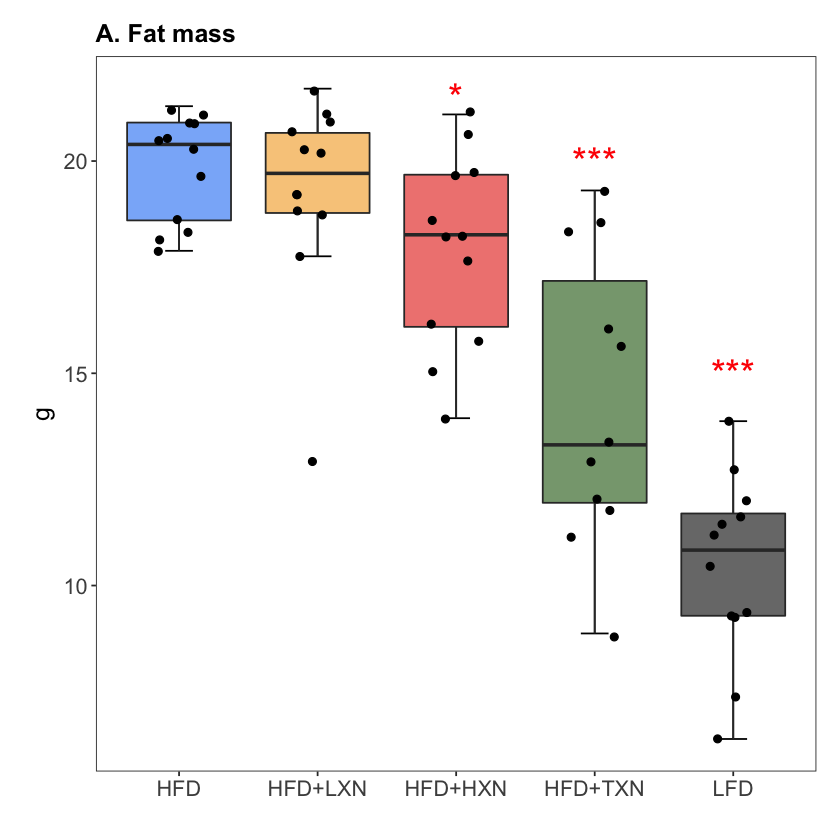

In [16]:
A

## - B. Hepatic lipidosis area percent

In [17]:
model <- lm(lipidosis_area_pct ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD    -3.98 2.82 54 -1.414  0.1630 
 LXN vs HFD    -2.81 2.82 54 -0.998  0.3225 
 HXN vs HFD    -6.27 2.82 54 -2.228  0.0301 
 TXN vs HFD    -9.24 2.88 54 -3.209  0.0022 


In [18]:
B <- ggplot(data = data, aes(x = vars2, y = lipidosis_area_pct, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="%",title="B. Hepatic lipidosis area percent") +
	theme_legend2()
label.df <- data.frame(vars2 = c("HFD+HXN", "HFD+TXN"),
                       lipidosis_area_pct = c(22, 20))
B <- B + geom_text(data = label.df, label = c("*", "**"), color='red', size = 8)

## - C. average energy expenditure

In [14]:
model <- lm(avgEE2 ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate     SE df t.ratio p.value
 LFD vs HFD -0.04550 0.0218 52 -2.090  0.0415 
 LXN vs HFD  0.00168 0.0218 52  0.077  0.9387 
 HXN vs HFD -0.05473 0.0228 52 -2.397  0.0202 
 TXN vs HFD -0.06780 0.0223 52 -3.046  0.0036 


In [19]:
C <- ggplot(data = data, aes(x = vars2, y = avgEE2, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="kcal/hr",title="C. Average energy expenditure") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+HXN", "HFD+TXN", "LFD"),
                       avgEE2 = c(0.6, 0.55, 0.58))
C <- C + geom_text(data = label.df, label = c("*", "**", "*"), color='red', size = 8)

In [20]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row1 <- (A | B | C) + plot_layout(nrow = 1, ncol=3)

In [30]:
lfd_Fat_mass_cal <- ggplotRegression(lm(Fat_mass ~ kkcal, data = lfd), "black") + 
                        labs(title = "A-1 LFD", x = "1000 kcal", y = "fat mass (g)")+ theme_legend2()
hfd_Fat_mass_cal <- ggplotRegression(lm(Fat_mass ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "A-2 HFD", x = "1000 kcal", y = "fat mass (g)")+ theme_legend2()
lxn_Fat_mass_cal <- ggplotRegression(lm(Fat_mass ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "A-3 HFD+LXN", x = "1000 kcal", y = "fat mass (g)")+ theme_legend2()
hxn_Fat_mass_cal <- ggplotRegression(lm(Fat_mass ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "A-4 HFD+HXN", x = "1000 kcal", y = "fat mass (g)")+ theme_legend2()
txn_Fat_mass_cal <- ggplotRegression(lm(Fat_mass ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "A-5 HFD+TXN", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()

In [31]:
lfd_lipidosis_area_pct_cal <- ggplotRegression(lm(lipidosis_area_pct ~ kkcal, data = lfd), "black") + 
                        labs(title = "B-1 LFD", x = "1000 kcal", y = "hepatic lipidosis area percent")+ theme_legend2()
hfd_lipidosis_area_pct_cal <- ggplotRegression(lm(lipidosis_area_pct ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "B-2 HFD", x = "1000 kcal", y = "hepatic lipidosis area percent")+ theme_legend2()
lxn_lipidosis_area_pct_cal <- ggplotRegression(lm(lipidosis_area_pct ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "B-3 HFD+LXN", x = "1000 kcal", y = "hepatic lipidosis area percent")+ theme_legend2()
hxn_lipidosis_area_pct_cal <- ggplotRegression(lm(lipidosis_area_pct ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "B-4 HFD+HXN", x = "1000 kcal", y = "hepatic lipidosis area percent")+ theme_legend2()
txn_lipidosis_area_pct_cal <- ggplotRegression(lm(lipidosis_area_pct ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "B-5 HFD+TXN", x = "1000 kcal", y = "hepatic lipidosis area percent")+ theme_legend2()

In [32]:
lfd_EE_cal <- ggplotRegression(lm(avgEE ~ kkcal, data = lfd), "black") + 
                        labs(title = "C-1 LFD", x = "1000 kcal", y = "energy expenditure")+ theme_legend2()
hfd_EE_cal <- ggplotRegression(lm(avgEE ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "C-2 HFD", x = "1000 kcal", y = "energy expenditure")+ theme_legend2()
lxn_EE_cal <- ggplotRegression(lm(avgEE ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "C-3 HFD+LXN", x = "1000 kcal", y = "energy expenditure")+ theme_legend2()
hxn_EE_cal <- ggplotRegression(lm(avgEE2 ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "C-4 HFD+HXN", x = "1000 kcal", y = "energy expenditure")+ theme_legend2()
txn_EE_cal <- ggplotRegression(lm(avgEE ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "C-5 HFD+TXN", x = "1000 kcal", y = "energy expenditure")+ theme_legend2()

In [33]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row2 <- (lfd_Fat_mass_cal | lfd_lipidosis_area_pct_cal | lfd_EE_cal) + plot_layout(nrow = 1, ncol = 3)

In [34]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row3 <- (hfd_Fat_mass_cal | hfd_lipidosis_area_pct_cal | hfd_EE_cal) + plot_layout(nrow = 1, ncol = 3)

In [35]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row4 <- (lxn_Fat_mass_cal | lxn_lipidosis_area_pct_cal | lxn_EE_cal) + plot_layout(nrow = 1, ncol = 3)

In [36]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row5 <- (hxn_Fat_mass_cal | hxn_lipidosis_area_pct_cal | hxn_EE_cal) + plot_layout(nrow = 1, ncol = 3)

In [37]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row6 <- (txn_Fat_mass_cal | txn_lipidosis_area_pct_cal | txn_EE_cal) + plot_layout(nrow = 1, ncol = 3)

## Put together

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



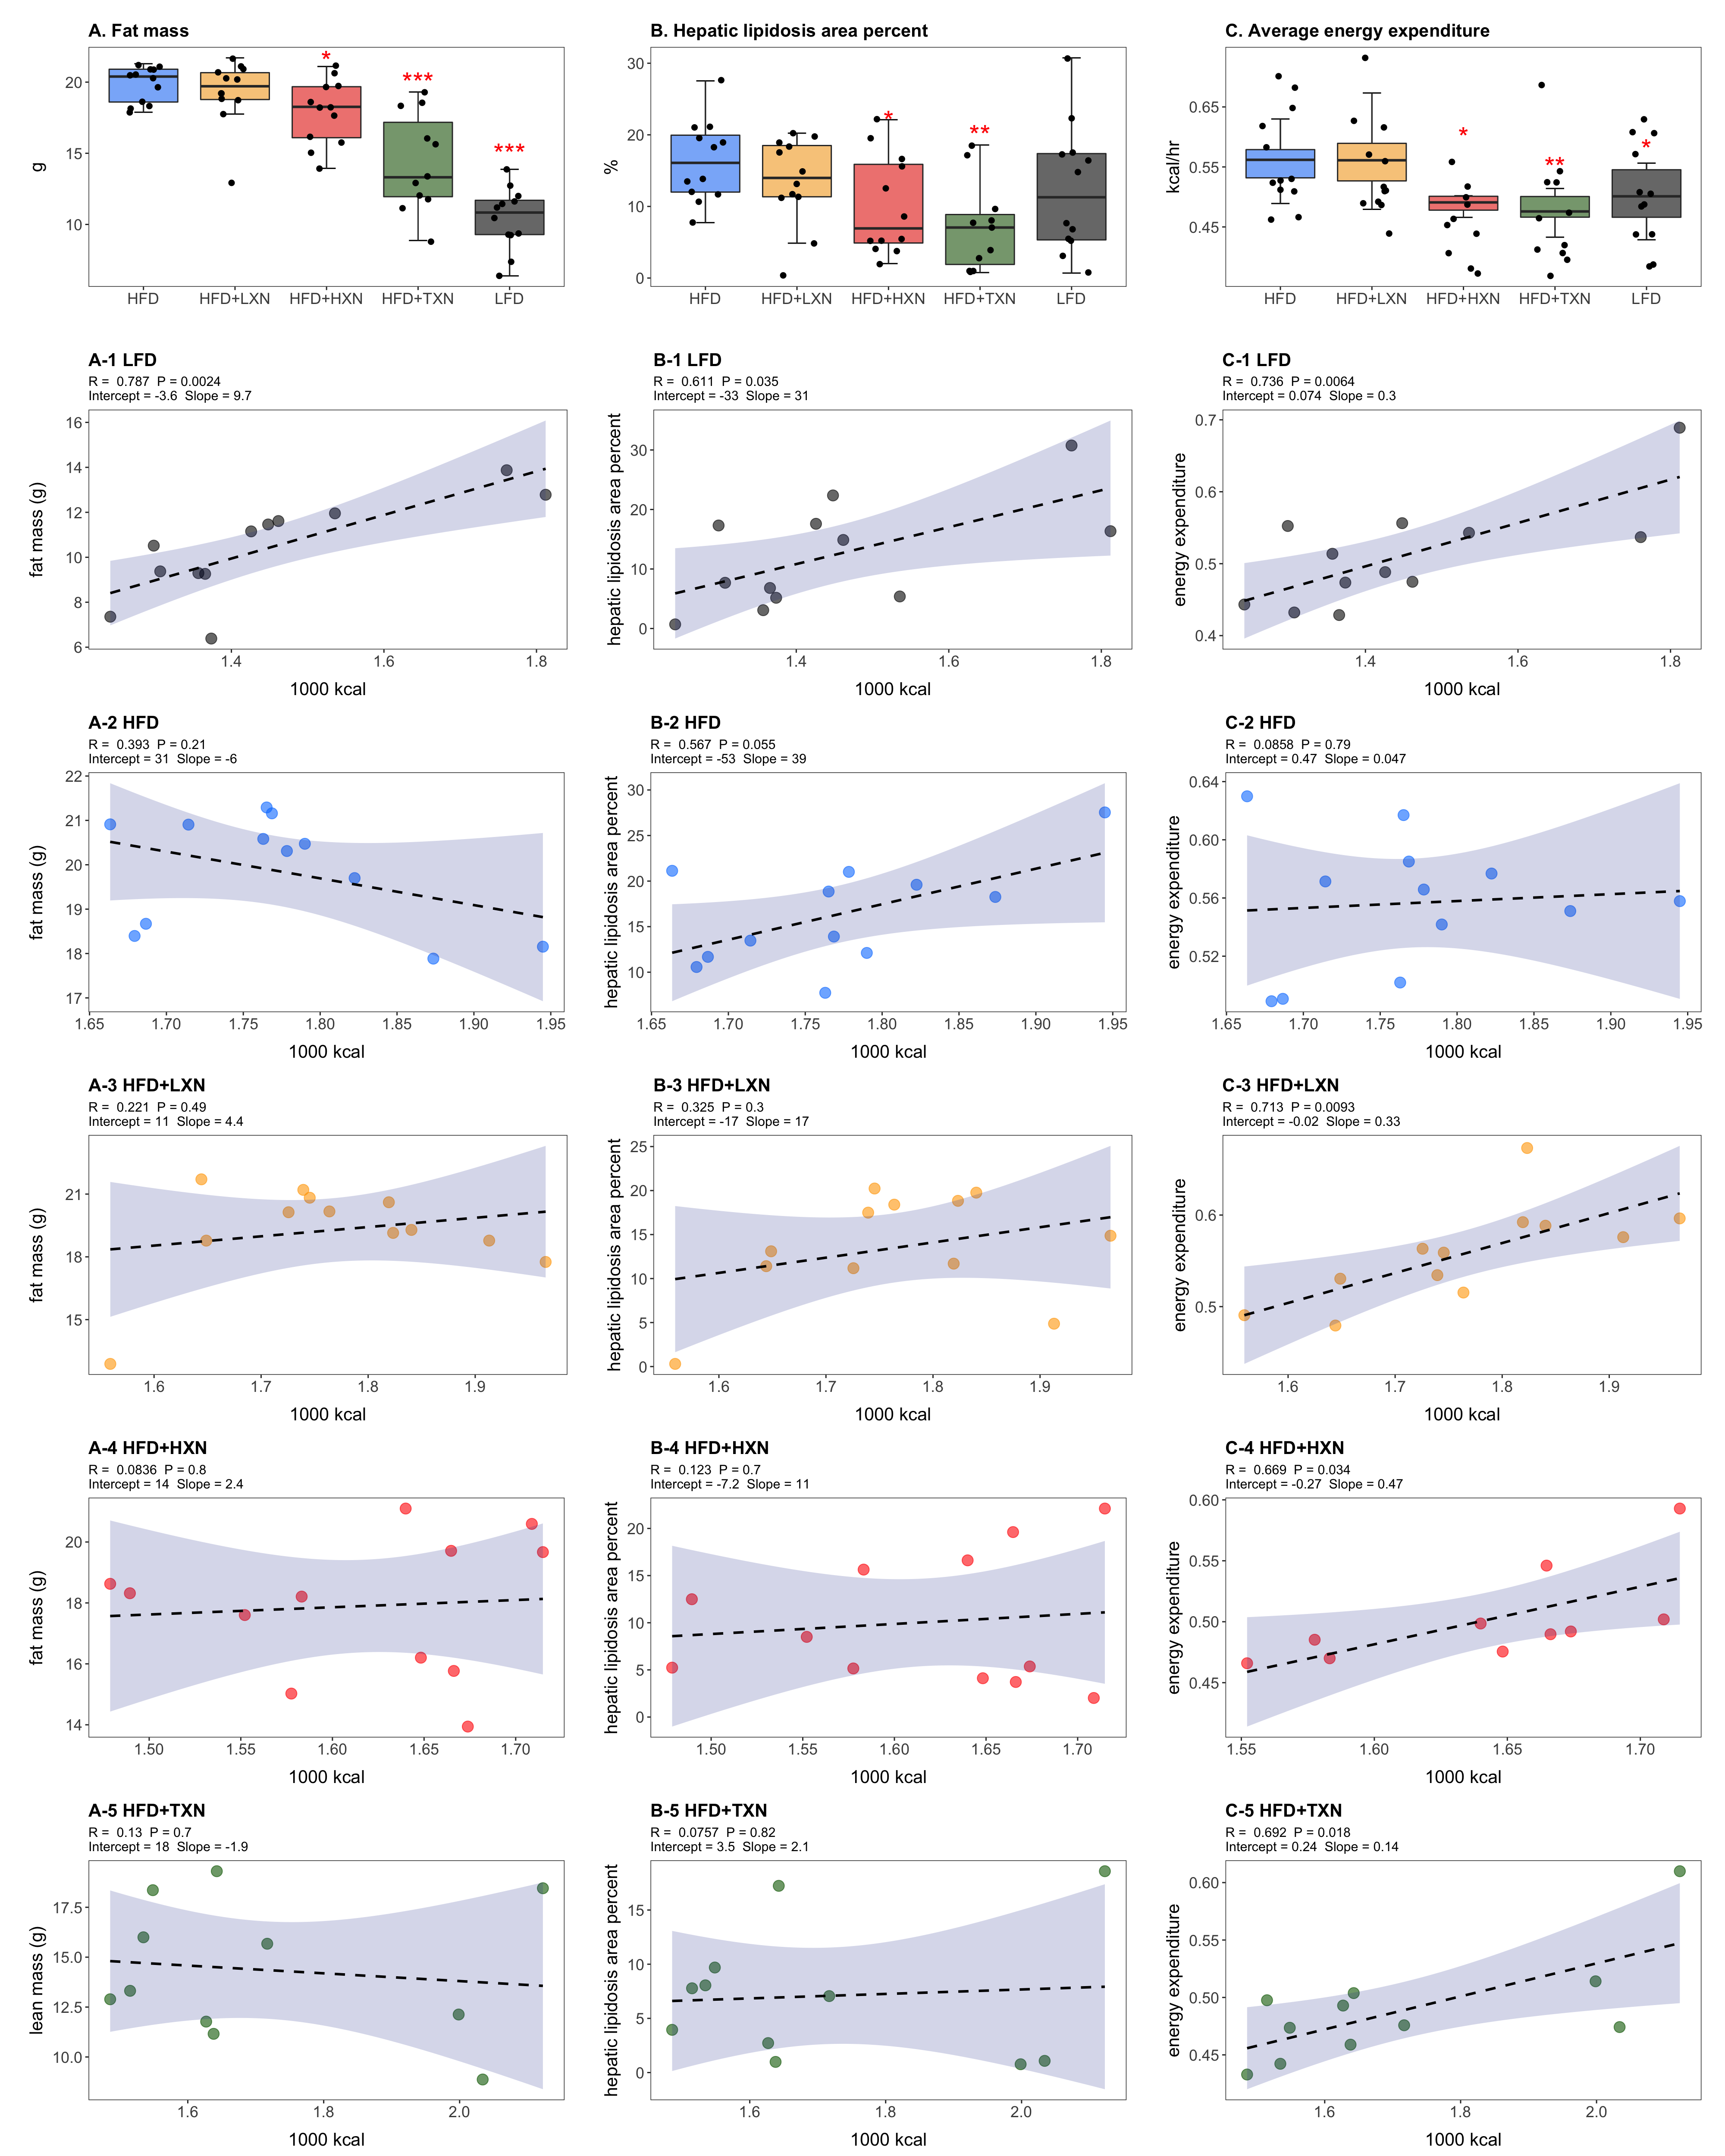

In [38]:
options(repr.plot.width = 20, repr.plot.height = 25, repr.plot.res = 200)
(figure2 <- wrap_plots(row1, row2, row3, row4, row5, row6, nrow=6))

In [39]:
graph2pdf(figure2, "figure2_update.pdf", width = 20, height = 25)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Exported graph as figure2_update.pdf

